In [21]:
# Import the required packages
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import csv
import random as rand
import io

%matplotlib inline


In [22]:
# Randomly generate a .csv for testing
def generateCSV(nRows: int, nCol: int, inRange: tuple, outRange: tuple) -> None:
    """Generates a .csv file given ``nRows`` and ``nCol`` using values between ``inRange`` and ``outRange``.

    Args:
        nRows (```int```): Number of rows
        nCol (```int```): Number of columns
        inRange (```tuple```): Range of input values
        outRange (```tuple```): Range of output values
    """
    with open('test.csv', 'w', newline='') as file:
        writer = csv.writer(file)

        if (nCol == 2):
            writer.writerow(["X", "Y"])
        elif (nCol == 3):
            writer.writerow(["X", "Y", "Z"])
            
        for i in range(nRows):
            row = []
            for j in range(nCol - 1):
                row.append(rand.uniform(inRange[0], inRange[1]))
            row.append(rand.uniform(outRange[0], outRange[1]))

            writer.writerow(row)


In [27]:
# Note: 'data.csv' should be formatted in a way where the dependent variable is the last column.
# For visualization's sake, you should only have a max of two independent variables.

# Read in the data from 'data.csv'
# Example of correctly formatted .csv is provided in 'example_data.csv'
generateCSV(nRows=100, nCol=3, inRange=(-10, 10), outRange=(-10_000, 10_000))
filename = input("Please enter the name of the .csv file.\nType 'example_2d' or 'example_3d' for examples.\nFile name (w/o extension): ")
data = pd.read_csv(f'{filename}.csv')

nRows = data.shape[0]
nCol = data.shape[1]

if (nCol < 2 or nCol > 3):
    raise RuntimeError(
        "There are too many or too few independent variables to create a regression curve.")

values = []
for i in range(nCol):
    values.append(data.iloc[:, i])


# By default, the regression order (r_o) is set to 3 so that is doesn't overfit the data too harshly.
r_o = 3

# Initialize the (r_o + 1) parameters (r_o weights for each input + a bias) to 0
params = []
for i in range((r_o * (nCol - 1)) + 1):
    params.append(0)

epochs = 10000
L = learningRate = 0.001


In [28]:
# Define an r_o order regression function for one or two independent variables
def regressionFn(p: list, v: list, r_o: int) -> pd.DataFrame:
    """Based on the regression order chosen, generates a ```DataFrame``` of all of the outputs from data points plugged into an n-order regression function.

    Args:
        p (list): A list of ```float``` parameters that can be updated by the gradient descent algorithm.
        v (list): A list of ```DataFrame``` for all of the input data values.

    Returns:
        pd.DataFrame: A ```DataFrame``` including all of the outputs of the regression function.
    """
    if (r_o == 3):
        if (nCol - 1 == 1):
            Y_pred = (p[0]*v[0].pow(3) +
                      p[1]*v[0].pow(2) +
                      p[2]*v[0] +
                      p[3])
        elif (nCol - 1 == 2):
            Y_pred = (p[0]*v[0].pow(3) + p[1]*v[1].pow(3) +
                      p[2]*v[0].pow(2) + p[3]*v[1].pow(2) +
                      p[4]*v[0] + p[5]*v[1] +
                      p[6])
    elif (r_o == 2):
        if (nCol - 1 == 1):
            Y_pred = (p[0]*v[0].pow(2) +
                      p[1]*v[0] +
                      p[2])
        elif ((nCol - 1) == 2):
            Y_pred = (p[0]*v[0].pow(2) + p[1]*v[1].pow(2) +
                      p[2]*v[0] + p[3]*v[1] +
                      p[4])
    elif (r_o == 1):
        if (nCol - 1 == 1):
            Y_pred = (p[0]*v[0] +
                      p[1])
        elif (nCol - 1 == 2):
            Y_pred = (p[0]*v[0] + p[1]*v[1] +
                      p[2])
    else:
        Y_pred = p[0]

    return Y_pred


In [29]:
# Run the gradient descent full-batch regression algorithm
for i in range(epochs):
    Y_pred = regressionFn(params, values, r_o)
    # Calculate the gradients of the mean squared error (MSE) loss function with respect to the parameters
    d_params = []
    for j in range(r_o + 1):
        for k in range(nCol - 1):
            d_params.insert(
                j + k,
                -2/nRows * sum(values[k].pow((r_o - j) /
                               (nCol-1)) * (values[-1] - Y_pred))
            )

    # Update the learning rate if current learning rate would cause a parameter to be NaN
    for j in range(len(params)):
        while(math.isnan(params[j] - L * d_params[j]) and L > 1e-15):
            L = L / 10

    # Update the parameters
    for j in range(len(params)):
        params[j] = params[j] - L * d_params[j]


print(params)
plottable = True
for i in range(len(params)):
    if(math.isnan(params[j])):
        plottable = False



[626.8060849275971, 1266.6810854234573]


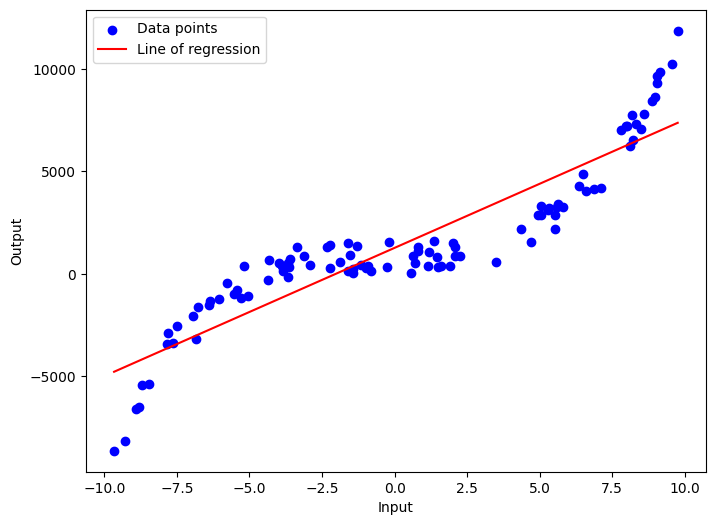

In [30]:
# Render a plot of the data and line of regression given the parameters are all finite
if(plottable):
    fig = plt.figure(figsize=(8.0, 6.0))


    def rotate_plot(frame_number, zarray, plot):
        plot[0].remove()
        plot[1].remove()
        ax.view_init(elev=30., azim=frame_number * rotation_rate)
        plot[0] = ax.scatter(zarray[0], zarray[1], zarray[2], c='blue')
        plot[1] = ax.scatter(zarray[0], zarray[1],
                            regressionFn(params, zarray, r_o), c='red')


    # If there is only one independent variable
    if (nCol == 2):
        plt.xlabel("Input")
        plt.ylabel("Output")

        plt.scatter(values[0], values[1], c='blue', label="Data points")

        plt.plot(values[0].sort_values(), regressionFn(
            params, values, r_o).sort_values(), '-r', label="Line of regression")
        plt.legend()

        plt.show()

    # If there are only two independent variables
    elif (nCol == 3):
        # Generate a .gif of the plot spinning about the z-axis
        ax = fig.add_subplot(111, projection='3d')

        plot = [
            ax.scatter(values[0], values[1], values[2], c='blue'),
            ax.scatter(values[0], values[1], regressionFn(
                params, values, r_o), c='red')
        ]
        fps = 165
        frn = 120  # Number of frames
        rotation_rate = 360 / frn

        ani = animation.FuncAnimation(
            fig, rotate_plot, frn, fargs=(values, plot), interval=1000 / fps)
        ani.save('3Dplot.gif')
else:
    print("Cannot plot the regression curve/plane to the given data; a parameter is NaN.")